The paper we are replicating here is : [N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR
INTERPRETABLE TIME SERIES FORECASTING](https://arxiv.org/pdf/1905.10437)

<img src="model.png" width=50% style="display: block; margin-left: auto; margin-right: auto;">

### 

### Preprocess the data

In [1]:
import pandas as pd
df = pd.read_csv('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [3]:
len(df), df.shape, df.size

(2787, (2787, 5), 13935)

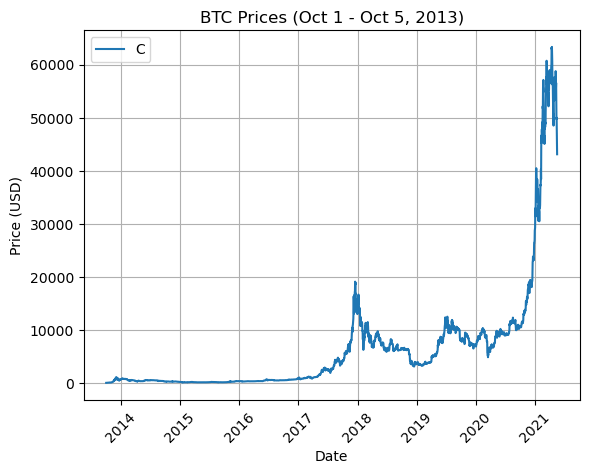

In [4]:
import matplotlib.pyplot as plt

plt.plot(df.index, df["Closing Price (USD)"])

plt.title('BTC Prices (Oct 1 - Oct 5, 2013)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(labels='Closing Price (USD)')
plt.grid(True)
plt.xticks(rotation=45);

### Importing time series data

In [5]:
import csv
from datetime import datetime

timesteps = []
btc_prices = []
with open('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
        btc_prices.append(float(line[2]))

timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

### Create training and test sets

In [6]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [7]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
btc_prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], btc_prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
# create train and test splits for time series data
split_size = int(0.8 * len(btc_prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], btc_prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], btc_prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

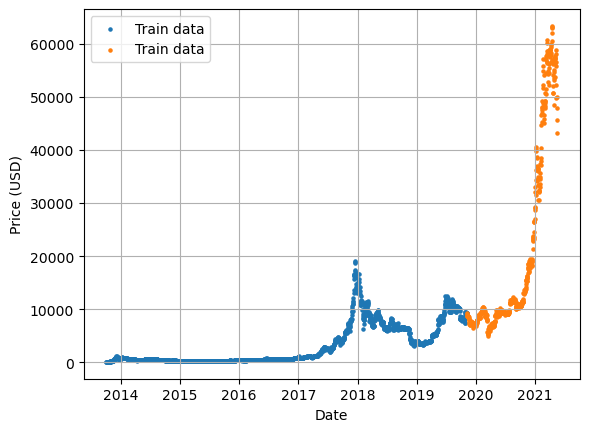

In [9]:
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Train data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend(fontsize=10)

### Creating a plotting function

In [10]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, s=5):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

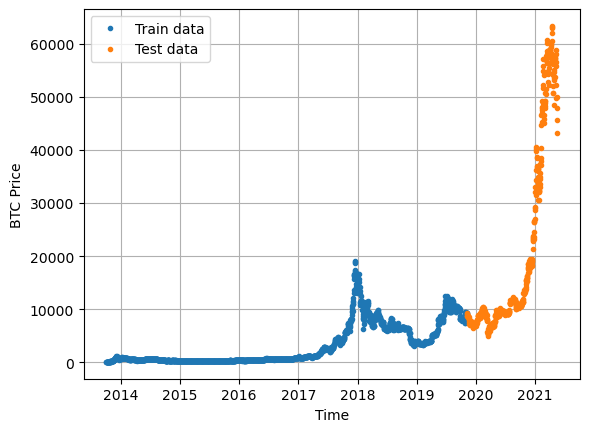

In [11]:
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')

## Modelling Experiments

Important terminologies
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

Experiments list:
- 0 Naïve model (baseline)
- Dense model, horizon = 1, window = 7
- Same as 1, horizon = 1, window = 30
- Same as 1, horizon = 7, window = 30
- Conv1D
- LSTM
- Same as 1 (but with multivariate data)
- N-BEATs Algorithm
- Ensemble (multiple models optimized on different loss functions)
- Future prediction model (model to predict future values)
- Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

$$\hat{y}_{t} = y_{t-1}$$
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [12]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

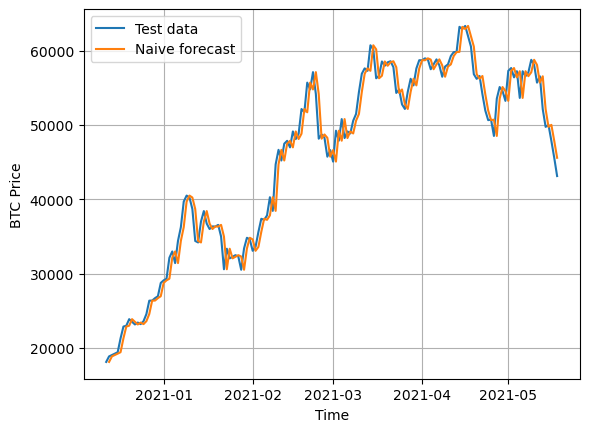

In [13]:
# plot forecast
# plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, start=400, format='-', label='Test data')
plot_time_series(X_test[1:], naive_forecast, start=400, format='-', label='Naive forecast')

In [14]:
import tensorflow as tf

In [15]:
# mase implementation
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [16]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [17]:
# function for evaluation metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [18]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Windowing our dataset
```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
print(f"We want to use: {btc_prices[:7]} to predict this: {btc_prices[7]}")

We want to use: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict this: 123.033


In [20]:
HORIZON = 1
WINDOW_SIZE = 7

In [21]:
# function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

In [22]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [23]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    # create a window of specific window_size
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # create a 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # index on the target array
    windowed_array = x[window_indexes]
    # get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [24]:
full_windows, full_labels = make_windows(btc_prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [25]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [26]:
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [27]:
# make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [28]:
# create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modelling checkpoint callback

In [29]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

# build the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_1_dense')

In [31]:
# compile the model
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [32]:
# fit the model
model_1_history = model_1.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 117ms/step - loss: 1468.2578 - mae: 1468.2578 - mse: 8642861.0000 - val_loss: 1771.3384 - val_mae: 1771.3384 - val_mse: 8604602.0000
Epoch 2/100
18/18 [==============================] - 1s 77ms/step - loss: 274.1952 - mae: 274.1952 - mse: 296719.4688 - val_loss: 1006.1655 - val_mae: 1006.1655 - val_mse: 3374890.2500
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 198.9453 - mae: 198.9453 - mse: 193901.2344 - val_loss: 1369.2188 - val_mae: 1369.2188 - val_mse: 4645720.0000
Epoch 4/100
18/18 [==============================] - 1s 82ms/step - loss: 172.5849 - mae: 172.5849 - mse: 155480.7188 - val_loss: 894.2128 - val_mae: 894.2128 - val_mse: 2554221.5000
Epoch 5/100
18/18 [==============================] - 1s 61ms/step - loss: 147.6823 - mae: 147.6823 - mse: 122480.3047 - val_loss: 792.9329 - val_mae: 792.9329 - val_mse: 2136201.5000
Epoch 6/100
18/18 [==============================] - 1s 64ms/step - loss: 13

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 583.4056 - mae: 583.4056 - mse: 1186782.1250


[583.4055786132812, 583.4055786132812, 1186782.125]

In [35]:
# load in saved best performing model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.7426 - mae: 568.7426 - mse: 1156754.3750


[568.7425537109375, 568.7425537109375, 1156754.375]

### Making forecasts with a model (on the test dataset)

In [36]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [37]:
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8807.355, 8771.844, 9049.316, 8744.039, 8720.416, 8734.537,
        8657.095, 8513.417, 8439.52 , 8526.765], dtype=float32)>)

In [38]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [39]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.74255,
 'mse': 1156754.4,
 'rmse': 1075.5251,
 'mape': 2.5615602,
 'mase': 0.99912316}

In [40]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

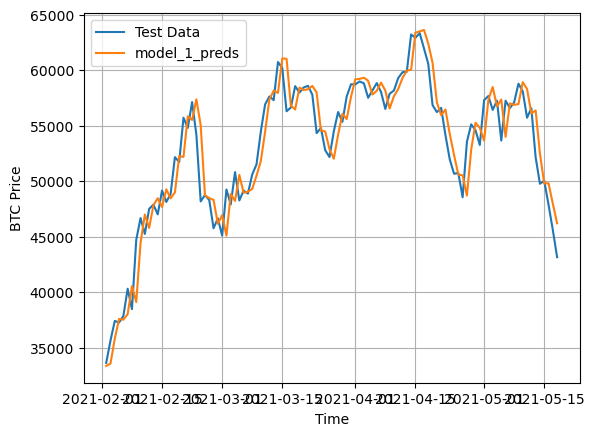

In [41]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset,
                 format='-',
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [42]:
HORIZON = 1
WINDOW_SIZE = 30

In [43]:
full_windows, full_labels = make_windows(btc_prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [44]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [45]:
tf.random.set_seed(42)

# build the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_2_dense')

In [46]:
# compile the model
model_2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [47]:
# fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 3s 118ms/step - loss: 1096.9500 - mae: 1096.9500 - mse: 5065358.5000 - val_loss: 2306.6296 - val_mae: 2306.6296 - val_mse: 13492915.0000
Epoch 2/100
18/18 [==============================] - 2s 120ms/step - loss: 440.5767 - mae: 440.5767 - mse: 816430.9375 - val_loss: 1624.5764 - val_mae: 1624.5764 - val_mse: 7221211.0000
Epoch 3/100
18/18 [==============================] - 2s 115ms/step - loss: 231.6059 - mae: 231.6059 - mse: 256695.7344 - val_loss: 1230.1241 - val_mae: 1230.1241 - val_mse: 4325923.0000
Epoch 4/100
18/18 [==============================] - 2s 89ms/step - loss: 209.9023 - mae: 209.9023 - mse: 209965.9844 - val_loss: 1185.2715 - val_mae: 1185.2715 - val_mse: 3849049.5000
Epoch 5/100
18/18 [==============================] - 1s 73ms/step - loss: 176.5124 - mae: 176.5124 - mse: 158966.5938 - val_loss: 921.9916 - val_mae: 921.9916 - val_mse: 2882814.5000
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - lo

In [48]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,609
Trainable params: 20,609
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 757.7870 - mae: 757.7870 - mse: 1662200.3750


[757.7870483398438, 757.7870483398438, 1662200.375]

In [50]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 602.1370 - mae: 602.1370 - mse: 1269335.2500


[602.1370239257812, 602.1370239257812, 1269335.25]

In [51]:
model_2_preds = make_preds(model_2, input_data=test_windows)
model_2_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8860.046 , 8915.623 , 8738.795 , 8575.064 , 8392.183 , 8420.471 ,
       8368.637 , 8260.026 , 8129.4443, 7786.5684], dtype=float32)>

In [52]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 602.137,
 'mse': 1269335.2,
 'rmse': 1126.6478,
 'mape': 2.7344334,
 'mase': 1.0525414}

In [53]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

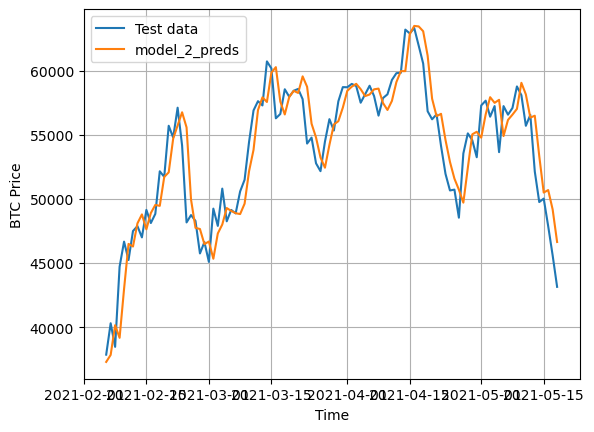

In [54]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format='-',
                 label='Test data')

plot_time_series(X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format='-',
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [55]:
HORIZON = 7
WINDOW_SIZE = 30

In [56]:
full_windows, full_labels = make_windows(btc_prices, horizon=HORIZON, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels)

(2751, 2751)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [58]:
tf.random.set_seed(42)

# build the model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_3_dense')

In [59]:
# compile the model
model_3.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [60]:
# fit the model
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 3s 121ms/step - loss: 1254.5068 - mae: 1254.5068 - mse: 7105957.5000 - val_loss: 3376.9456 - val_mae: 3376.9456 - val_mse: 28277886.0000
Epoch 2/100
18/18 [==============================] - 1s 82ms/step - loss: 506.0131 - mae: 506.0131 - mse: 1139338.7500 - val_loss: 2240.9624 - val_mae: 2240.9624 - val_mse: 14382480.0000
Epoch 3/100
18/18 [==============================] - 1s 83ms/step - loss: 392.0203 - mae: 392.0203 - mse: 728591.0000 - val_loss: 1828.5227 - val_mae: 1828.5227 - val_mse: 10170616.0000
Epoch 4/100
18/18 [==============================] - 2s 113ms/step - loss: 340.6706 - mae: 340.6706 - mse: 561257.6875 - val_loss: 1622.8850 - val_mae: 1622.8850 - val_mse: 8329827.5000
Epoch 5/100
18/18 [==============================] - 1s 86ms/step - loss: 312.8489 - mae: 312.8489 - mse: 470704.7812 - val_loss: 1591.0088 - val_mae: 1591.0088 - val_mse: 8004072.0000
Epoch 6/100
18/18 [==============================] - 2s 103ms/step

In [61]:
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3968      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 7)                 903       
                                                                 
Total params: 21,383
Trainable params: 21,383
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1323.8036 - mae: 1323.8036 - mse: 5637931.5000


[1323.8035888671875, 1323.8035888671875, 5637931.5]

In [63]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1216.4534 - mae: 1216.4534 - mse: 5298576.0000


[1216.453369140625, 1216.453369140625, 5298576.0]

In [64]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9404.573 , 9406.491 , 9357.16  , 9479.808 , 9578.086 , 9593.442 ,
        9834.873 ],
       [9058.63  , 9036.041 , 8912.135 , 9079.935 , 9204.575 , 9199.885 ,
        9363.781 ],
       [8908.8545, 8887.729 , 8755.17  , 8823.925 , 8969.771 , 9043.662 ,
        9102.4375],
       [9014.02  , 9058.917 , 8882.648 , 8975.67  , 9070.841 , 9290.765 ,
        9178.617 ],
       [8915.59  , 8947.511 , 8836.829 , 8899.399 , 8936.898 , 9130.939 ,
        9051.923 ]], dtype=float32)>

In [65]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [66]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': array([  728.847   ,   383.7832  ,   273.94992 ,   440.75934 ,
          405.5222  ,   383.49728 ,   511.08176 ,   432.872   ,
          449.8289  ,   536.26825 ,   701.6957  ,   680.07245 ,
          762.7051  ,   911.2051  ,   592.64105 ,   199.67174 ,
          160.65367 ,   238.81801 ,   251.9255  ,   244.14021 ,
          184.76926 ,   232.12932 ,   394.79477 ,   353.27777 ,
          193.42879 ,   128.00133 ,   147.64076 ,   156.58015 ,
          171.69295 ,   334.33823 ,   335.20963 ,   524.3883  ,
          401.9052  ,   396.0478  ,   273.26617 ,   320.09195 ,
          310.38873 ,   267.44043 ,   232.02336 ,   235.74232 ,
          563.8099  ,   112.25293 ,    72.42529 ,   130.71916 ,
          181.3291  ,    94.65904 ,    59.557896,   103.96882 ,
          136.37737 ,   125.76911 ,   146.80127 ,   114.84284 ,
          238.1573  ,   143.35457 ,   182.68709 ,   319.81537 ,
          552.9776  ,   479.17026 ,   464.40207 ,   629.49615 ,
          294.71512 ,   201.67146

In [67]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1216.4534 - mae: 1216.4534 - mse: 5298576.0000


[1216.453369140625, 1216.453369140625, 5298576.0]

In [68]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1216.4534

In [69]:
model_2_results["mae"].ndim

0

In [70]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [71]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1216.4534,
 'mse': 5298576.0,
 'rmse': 1396.8339,
 'mape': 5.4893785,
 'mase': 2.1646104}

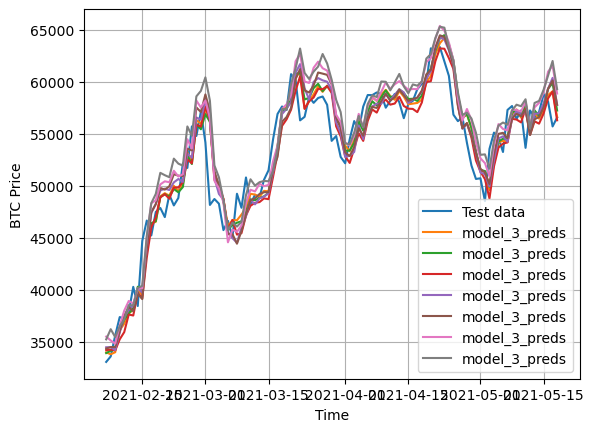

In [72]:
offset = 450
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format='-',
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds,
                 start=offset,
                 format='-',
                 label="model_3_preds")

In [73]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9404.573, 9406.491, 9357.16 , 9479.808, 9578.086, 9593.442,
       9834.873], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9522.062>

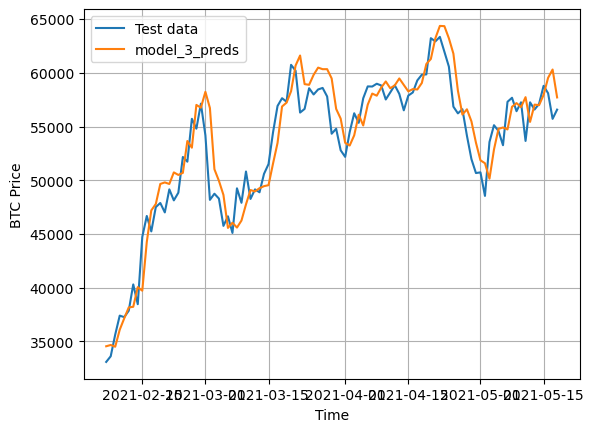

In [75]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset,
                 format='-',
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

### Model is performing the best so far

<Axes: >

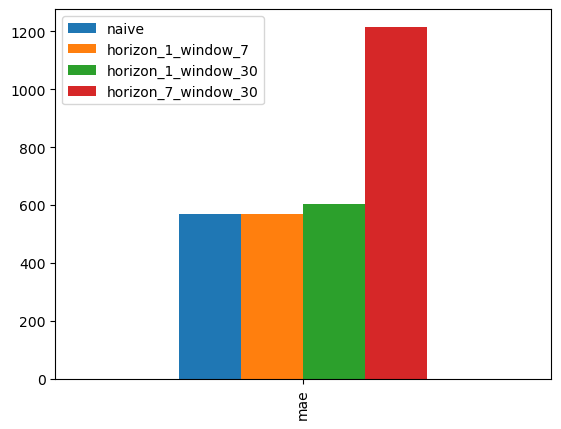

In [76]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(kind="bar")

## Model 4: Conv1D

In [77]:
HORIZON = 1
WINDOW_SIZE = 7

In [79]:
full_windows, full_labels = make_windows(btc_prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [80]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [81]:
train_windows[0].shape

(7,)

In [82]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [85]:
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [89]:
tf.random.set_seed(42)

# build the model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=7, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

In [90]:
# compile the model
model_4.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [91]:
# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 1949.1658 - mae: 1949.1658 - mse: 10437095.0000 

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 4s 166ms/step - loss: 1673.8491 - mae: 1673.8491 - mse: 8580032.0000 - val_loss: 1093.6313 - val_mae: 1093.6313 - val_mse: 3936102.2500
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 351.2522 - mae: 351.2522 - mse: 490364.5312 - val_loss: 1735.4906 - val_mae: 1735.4906 - val_mse: 7258699.0000
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 239.3834 - mae: 239.3834 - mse: 265706.6562

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 112ms/step - loss: 235.4812 - mae: 235.4812 - mse: 263065.5000 - val_loss: 1079.3029 - val_mae: 1079.3029 - val_mse: 3781145.2500
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 197.1944 - mae: 197.1944 - mse: 198391.2188

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 124ms/step - loss: 198.4407 - mae: 198.4407 - mse: 198255.3594 - val_loss: 1064.4501 - val_mae: 1064.4501 - val_mse: 3821963.5000
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 192.9622 - mae: 192.9622 - mse: 193687.7188

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 91ms/step - loss: 189.8517 - mae: 189.8517 - mse: 187811.5469 - val_loss: 1052.5854 - val_mae: 1052.5854 - val_mse: 3622817.5000
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 184.9666 - mae: 184.9666 - mse: 170886.3281

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 108ms/step - loss: 186.9288 - mae: 186.9288 - mse: 183949.1719 - val_loss: 1047.1547 - val_mae: 1047.1547 - val_mse: 3707105.5000
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 190.8994 - mae: 190.8994 - mse: 193877.0312

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 92ms/step - loss: 186.1219 - mae: 186.1219 - mse: 182671.9531 - val_loss: 1014.7392 - val_mae: 1014.7392 - val_mse: 3469064.7500
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 179.8930 - mae: 179.8930 - mse: 174866.1406

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 109ms/step - loss: 180.3126 - mae: 180.3126 - mse: 173805.6406 - val_loss: 1013.5044 - val_mae: 1013.5044 - val_mse: 3353744.2500
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 178.0839 - mae: 178.0839 - mse: 169822.8906 - val_loss: 1022.2484 - val_mae: 1022.2484 - val_mse: 3309280.7500
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 172.8966 - mae: 172.8966 - mse: 163719.9219

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 84ms/step - loss: 175.5203 - mae: 175.5203 - mse: 165749.4844 - val_loss: 979.9638 - val_mae: 979.9638 - val_mse: 3153539.7500
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 173.3557 - mae: 173.3557 - mse: 162334.1406

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 109ms/step - loss: 172.4715 - mae: 172.4715 - mse: 159498.6562 - val_loss: 953.0632 - val_mae: 953.0632 - val_mse: 3076638.7500
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 171.6482 - mae: 171.6482 - mse: 155958.3125 - val_loss: 975.6070 - val_mae: 975.6070 - val_mse: 2982083.7500
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 167.1819 - mae: 167.1819 - mse: 148343.1250 - val_loss: 992.9960 - val_mae: 992.9960 - val_mse: 2981528.0000
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 161.8685 - mae: 161.8685 - mse: 141227.7344

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 85ms/step - loss: 163.6167 - mae: 163.6167 - mse: 143930.2031 - val_loss: 922.2769 - val_mae: 922.2769 - val_mse: 2745370.5000
Epoch 15/100
18/18 [==============================] - 0s 8ms/step - loss: 161.8273 - mae: 161.8273 - mse: 142696.4375 - val_loss: 926.2521 - val_mae: 926.2521 - val_mse: 2699998.2500
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 155.2063 - mae: 155.2063 - mse: 131428.0625

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 121ms/step - loss: 157.0737 - mae: 157.0737 - mse: 135940.0156 - val_loss: 873.6539 - val_mae: 873.6539 - val_mse: 2542923.0000
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 154.3395 - mae: 154.3395 - mse: 131617.7500 - val_loss: 909.3658 - val_mae: 909.3658 - val_mse: 2560105.7500
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 161.9754 - mae: 161.9754 - mse: 113236.2266

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 86ms/step - loss: 152.4875 - mae: 152.4875 - mse: 128839.4062 - val_loss: 869.0725 - val_mae: 869.0725 - val_mse: 2416736.2500
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 148.6608 - mae: 148.6608 - mse: 122719.5234 - val_loss: 877.5691 - val_mae: 877.5692 - val_mse: 2393055.5000
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 148.1058 - mae: 148.1058 - mse: 122488.1094

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 114ms/step - loss: 149.1569 - mae: 149.1569 - mse: 123148.5156 - val_loss: 838.7211 - val_mae: 838.7211 - val_mse: 2374002.0000
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 213.2566 - mae: 213.2566 - mse: 206959.9062

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 94ms/step - loss: 147.3409 - mae: 147.3409 - mse: 120736.5625 - val_loss: 797.1978 - val_mae: 797.1978 - val_mse: 2141681.2500
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 142.9629 - mae: 142.9629 - mse: 113644.1172 - val_loss: 809.0780 - val_mae: 809.0780 - val_mse: 2113531.5000
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 140.3795 - mae: 140.3795 - mse: 110499.0391 - val_loss: 798.6909 - val_mae: 798.6909 - val_mse: 2054389.8750
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 140.0639 - mae: 140.0639 - mse: 107753.1250 - val_loss: 797.7911 - val_mae: 797.7911 - val_mse: 2020504.3750
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 150.2997 - mae: 150.2997 - mse: 91393.4219

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 107ms/step - loss: 136.5008 - mae: 136.5008 - mse: 105717.3047 - val_loss: 756.9410 - val_mae: 756.9410 - val_mse: 1897954.7500
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 134.0716 - mae: 134.0716 - mse: 96654.1094

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 94ms/step - loss: 134.2714 - mae: 134.2714 - mse: 101595.3516 - val_loss: 742.0403 - val_mae: 742.0403 - val_mse: 1881927.3750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 198.7592 - mae: 198.7592 - mse: 192025.4688

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 94ms/step - loss: 134.0440 - mae: 134.0440 - mse: 102077.2344 - val_loss: 738.4584 - val_mae: 738.4584 - val_mse: 1859644.1250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 137.6983 - mae: 137.6983 - mse: 94118.4453

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 115ms/step - loss: 131.0620 - mae: 131.0620 - mse: 97722.2109 - val_loss: 722.3445 - val_mae: 722.3444 - val_mse: 1739899.6250
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 122.4598 - mae: 122.4598 - mse: 75363.5625

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 94ms/step - loss: 128.8204 - mae: 128.8204 - mse: 95016.3594 - val_loss: 711.9302 - val_mae: 711.9302 - val_mse: 1696130.7500
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 132.2125 - mae: 132.2125 - mse: 95490.2812 - val_loss: 877.4258 - val_mae: 877.4258 - val_mse: 2155591.7500
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 138.5766 - mae: 138.5766 - mse: 103244.1875 - val_loss: 783.9260 - val_mae: 783.9260 - val_mse: 1851495.6250
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 129.0882 - mae: 129.0882 - mse: 92172.0625 - val_loss: 715.6562 - val_mae: 715.6562 - val_mse: 1656363.1250
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 153.1358 - mae: 153.1358 - mse: 160371.1250

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 113ms/step - loss: 126.9463 - mae: 126.9463 - mse: 87813.7734 - val_loss: 698.4059 - val_mae: 698.4059 - val_mse: 1603021.8750
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 135.2995 - mae: 135.2995 - mse: 119962.2344

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 94ms/step - loss: 124.3781 - mae: 124.3781 - mse: 88907.2656 - val_loss: 677.3134 - val_mae: 677.3134 - val_mse: 1545314.1250
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 110.8325 - mae: 110.8325 - mse: 59586.3984

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 104ms/step - loss: 122.6148 - mae: 122.6148 - mse: 88339.9844 - val_loss: 670.9304 - val_mae: 670.9304 - val_mse: 1519477.8750
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 124.0876 - mae: 124.0876 - mse: 86928.9531 - val_loss: 712.5311 - val_mae: 712.5311 - val_mse: 1608308.2500
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 156.2116 - mae: 156.2116 - mse: 123500.2500

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 89ms/step - loss: 123.4715 - mae: 123.4715 - mse: 86827.5938 - val_loss: 658.8270 - val_mae: 658.8270 - val_mse: 1512598.5000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 115.1548 - mae: 115.1548 - mse: 78381.6562

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 120ms/step - loss: 121.5392 - mae: 121.5392 - mse: 86736.3750 - val_loss: 651.2720 - val_mae: 651.2720 - val_mse: 1476587.1250
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 121.1503 - mae: 121.1503 - mse: 84757.0781 - val_loss: 675.8853 - val_mae: 675.8853 - val_mse: 1559314.8750
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 118.7968 - mae: 118.7968 - mse: 84034.6328 - val_loss: 659.1022 - val_mae: 659.1022 - val_mse: 1455027.6250
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 110.2541 - mae: 110.2541 - mse: 60433.8438

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 112ms/step - loss: 119.6039 - mae: 119.6039 - mse: 84559.5234 - val_loss: 639.5562 - val_mae: 639.5562 - val_mse: 1431183.5000
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 114.6467 - mae: 114.6467 - mse: 68309.0391

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 3s 149ms/step - loss: 122.7016 - mae: 122.7016 - mse: 87240.5547 - val_loss: 636.1203 - val_mae: 636.1203 - val_mse: 1395261.2500
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 93.6992 - mae: 93.6992 - mse: 60640.3359

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 131ms/step - loss: 116.4874 - mae: 116.4874 - mse: 80742.4141 - val_loss: 631.3182 - val_mae: 631.3182 - val_mse: 1394650.2500
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 117.1909 - mae: 117.1909 - mse: 80608.0469 - val_loss: 631.3205 - val_mae: 631.3205 - val_mse: 1396578.2500
Epoch 45/100
18/18 [==============================] - ETA: 0s - loss: 116.9844 - mae: 116.9844 - mse: 81689.6094

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 108ms/step - loss: 116.9844 - mae: 116.9844 - mse: 81689.6094 - val_loss: 627.5562 - val_mae: 627.5562 - val_mse: 1365224.6250
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7008 - mae: 116.7008 - mse: 80055.5625 - val_loss: 634.6445 - val_mae: 634.6445 - val_mse: 1373439.5000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 117.4933 - mae: 117.4933 - mse: 81324.3906 - val_loss: 701.9419 - val_mae: 701.9419 - val_mse: 1537109.1250
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 119.9951 - mae: 119.9951 - mse: 77377.1562

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 88ms/step - loss: 115.7399 - mae: 115.7399 - mse: 79374.4375 - val_loss: 622.7297 - val_mae: 622.7297 - val_mse: 1341375.2500
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 115.3188 - mae: 115.3188 - mse: 79451.9062 - val_loss: 628.1776 - val_mae: 628.1776 - val_mse: 1350416.2500
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 117.0985 - mae: 117.0985 - mse: 79556.5938 - val_loss: 622.9243 - val_mae: 622.9243 - val_mse: 1336392.3750
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 93.7766 - mae: 93.7766 - mse: 52512.7500

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 132ms/step - loss: 115.1684 - mae: 115.1684 - mse: 78000.4297 - val_loss: 617.4446 - val_mae: 617.4446 - val_mse: 1322286.2500
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 116.7399 - mae: 116.7399 - mse: 80712.5625 - val_loss: 620.9155 - val_mae: 620.9155 - val_mse: 1351608.0000
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7689 - mae: 116.7689 - mse: 79581.6562 - val_loss: 624.7674 - val_mae: 624.7674 - val_mse: 1333882.7500
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3804 - mae: 117.3804 - mse: 79424.6953 - val_loss: 631.7254 - val_mae: 631.7254 - val_mse: 1346826.3750
Epoch 55/100
18/18 [==============================] - ETA: 0s - loss: 115.5217 - mae: 115.5217 - mse: 79298.8438 

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 123ms/step - loss: 115.5217 - mae: 115.5217 - mse: 79298.8438 - val_loss: 606.1756 - val_mae: 606.1756 - val_mse: 1291681.1250
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1415 - mae: 114.1415 - mse: 77212.5859 - val_loss: 797.3997 - val_mae: 797.3997 - val_mse: 1899962.2500
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 137.9776 - mae: 137.9776 - mse: 94920.7578 - val_loss: 613.3677 - val_mae: 613.3677 - val_mse: 1322408.2500
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 122.3899 - mae: 122.3899 - mse: 83771.4922 - val_loss: 641.3041 - val_mae: 641.3041 - val_mse: 1393133.8750
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8918 - mae: 111.8918 - mse: 75530.2656 - val_loss: 607.3737 - val_mae: 607.3737 - val_mse: 1304737.0000
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9617 - mae: 111.9617 - 

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 108ms/step - loss: 112.5654 - mae: 112.5654 - mse: 77414.1797 - val_loss: 597.0481 - val_mae: 597.0481 - val_mse: 1266725.5000
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7927 - mae: 110.7927 - mse: 74769.1250 - val_loss: 610.3488 - val_mae: 610.3488 - val_mse: 1306854.8750
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 114.4147 - mae: 114.4147 - mse: 78022.8906

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 1s 88ms/step - loss: 114.1957 - mae: 114.1957 - mse: 77668.0781 - val_loss: 596.0093 - val_mae: 596.0093 - val_mse: 1260164.0000
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4235 - mae: 112.4235 - mse: 75483.3906 - val_loss: 644.0176 - val_mae: 644.0176 - val_mse: 1358288.2500
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4919 - mae: 113.4919 - mse: 76190.3203 - val_loss: 599.1364 - val_mae: 599.1364 - val_mse: 1275021.3750
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 120.3595 - mae: 120.3595 - mse: 84297.9375

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 108ms/step - loss: 111.3470 - mae: 111.3470 - mse: 74922.6797 - val_loss: 595.2995 - val_mae: 595.2995 - val_mse: 1253022.2500
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9126 - mae: 110.9126 - mse: 74427.9141 - val_loss: 656.2576 - val_mae: 656.2576 - val_mse: 1412966.2500
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 116.6406 - mae: 116.6406 - mse: 74475.3203 - val_loss: 772.2031 - val_mae: 772.2031 - val_mse: 1779066.0000
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 131.3892 - mae: 131.3892 - mse: 88160.4766 - val_loss: 708.8974 - val_mae: 708.8974 - val_mse: 1568497.2500
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 140.1185 - mae: 140.1185 - mse: 129093.7578

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 106ms/step - loss: 117.9798 - mae: 117.9798 - mse: 79327.5391 - val_loss: 585.4509 - val_mae: 585.4509 - val_mse: 1235825.7500
Epoch 71/100
18/18 [==============================] - 0s 10ms/step - loss: 111.6950 - mae: 111.6950 - mse: 74159.3672 - val_loss: 588.7877 - val_mae: 588.7877 - val_mse: 1237867.0000
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8560 - mae: 110.8560 - mse: 74577.3984 - val_loss: 586.3670 - val_mae: 586.3670 - val_mse: 1232893.3750
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1422 - mae: 111.1422 - mse: 74419.7188 - val_loss: 623.6613 - val_mae: 623.6613 - val_mse: 1321341.7500
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0459 - mae: 111.0459 - mse: 74602.4297 - val_loss: 602.4421 - val_mae: 602.4421 - val_mse: 1271261.8750
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 111.5632 - mae: 111.5632 -

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 117ms/step - loss: 111.1821 - mae: 111.1821 - mse: 73133.4375 - val_loss: 584.8138 - val_mae: 584.8138 - val_mse: 1229180.5000
Epoch 78/100
15/18 [========================>.....] - ETA: 0s - loss: 109.3084 - mae: 109.3084 - mse: 70864.3828

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 111ms/step - loss: 109.5753 - mae: 109.5753 - mse: 72554.4375 - val_loss: 579.9722 - val_mae: 579.9722 - val_mse: 1217622.1250
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4723 - mae: 109.4723 - mse: 74490.2344 - val_loss: 586.8060 - val_mae: 586.8060 - val_mse: 1232608.7500
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4550 - mae: 119.4550 - mse: 128455.1797

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 127ms/step - loss: 109.8259 - mae: 109.8259 - mse: 73653.1250 - val_loss: 578.4904 - val_mae: 578.4904 - val_mse: 1212173.1250
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 92.8723 - mae: 92.8723 - mse: 44060.7344

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 109ms/step - loss: 109.1798 - mae: 109.1798 - mse: 72751.2734 - val_loss: 577.7860 - val_mae: 577.7860 - val_mse: 1209785.6250
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 200.7155 - mae: 200.7155 - mse: 245172.6562

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 119ms/step - loss: 115.4080 - mae: 115.4080 - mse: 77919.1562 - val_loss: 577.3284 - val_mae: 577.3284 - val_mse: 1207611.3750
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 113.5311 - mae: 113.5311 - mse: 75772.4375 - val_loss: 644.8434 - val_mae: 644.8434 - val_mse: 1362612.1250
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 115.9388 - mae: 115.9388 - mse: 74403.0859 - val_loss: 582.2336 - val_mae: 582.2336 - val_mse: 1218951.5000
Epoch 85/100
15/18 [========================>.....] - ETA: 0s - loss: 106.4175 - mae: 106.4175 - mse: 70361.6562

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 123ms/step - loss: 109.9953 - mae: 109.9953 - mse: 74058.6797 - val_loss: 576.4972 - val_mae: 576.4972 - val_mse: 1203991.7500
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9751 - mae: 108.9751 - mse: 72403.5156 - val_loss: 611.6108 - val_mae: 611.6108 - val_mse: 1265373.0000
Epoch 87/100
16/18 [=========================>....] - ETA: 0s - loss: 108.9463 - mae: 108.9463 - mse: 69516.6172

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 125ms/step - loss: 109.7524 - mae: 109.7524 - mse: 71651.2031 - val_loss: 574.8417 - val_mae: 574.8417 - val_mse: 1199706.8750
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4001 - mae: 109.4001 - mse: 73121.8281 - val_loss: 599.0573 - val_mae: 599.0573 - val_mse: 1250056.6250
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3440 - mae: 111.3440 - mse: 72465.9062 - val_loss: 580.6749 - val_mae: 580.6749 - val_mse: 1212602.7500
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6199 - mae: 107.6199 - mse: 70077.6016 - val_loss: 642.0657 - val_mae: 642.0657 - val_mse: 1332296.1250
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7442 - mae: 110.7442 - mse: 73560.5156 - val_loss: 625.2095 - val_mae: 625.2095 - val_mse: 1308493.7500
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0315 - mae: 111.0315 - 

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 109ms/step - loss: 109.1492 - mae: 109.1492 - mse: 71858.5703 - val_loss: 573.5949 - val_mae: 573.5949 - val_mse: 1191264.8750
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 106.0504 - mae: 106.0504 - mse: 67616.3047 

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


18/18 [==============================] - 2s 121ms/step - loss: 108.7165 - mae: 108.7165 - mse: 72034.7734 - val_loss: 572.2958 - val_mae: 572.2958 - val_mse: 1189115.5000
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0399 - mae: 110.0399 - mse: 71316.5391 - val_loss: 622.3369 - val_mae: 622.3369 - val_mse: 1284048.7500


In [92]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            6400      
                                                                 
 dense_10 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [93]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 622.3369 - mae: 622.3369 - mse: 1284048.7500


[622.3369140625, 622.3369140625, 1284048.75]

In [94]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 572.2958 - mae: 572.2958 - mse: 1189115.5000


[572.2957763671875, 572.2957763671875, 1189115.5]

In [95]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8898.703, 8789.265, 9022.735, 8799.15 , 8736.327, 8769.601,
       8683.589, 8537.644, 8477.204, 8528.398], dtype=float32)>

In [96]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 572.2958,
 'mse': 1189115.4,
 'rmse': 1090.4657,
 'mape': 2.552925,
 'mase': 1.0053651}

In [97]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}